# Team D Data For Housing Project: Exploration Housing Quality in Oakland

In [57]:
import pandas as pd
import geopandas as gpd
import numpy as np

#mapping libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Importing and Readying the Housing Habitability Data:

Tasks:
- read in csv which includes address, a simplified address (Address_recode doesn't include unit numbers, number of complaints, lat, long)
- drop all the extra columns
- set the lat and long as geometry
- read invCA census tracts
- spatially join the census tracts with the hh complaints so that each record has a census tract associated
- drop all uneccessary columns

In [12]:
#read in housing habitability data, EACH TEAM MEMBER WILL HAVE DIFFERENT PATH
#is there a way to do this directly from the google drive?
hh = pd.read_csv(r'C:\Users\amarq\Python_Projects\raw_data\Oakland Housing Habitability Complaints_2014to2018_geocoded.csv')
#I'm realizing that I made a terrible mistake saving this as a csv and not a geojson, so, instead, I'm redoing the sjoin here

In [13]:
hh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2776 entries, 0 to 2775
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   STATEFP         2776 non-null   int64  
 1   COUNTYFP        2776 non-null   int64  
 2   TRACTCE         2776 non-null   int64  
 3   AFFGEOID        2776 non-null   object 
 4   GEOID           2776 non-null   int64  
 5   NAME            2776 non-null   float64
 6   LSAD            2776 non-null   object 
 7   ALAND           2776 non-null   int64  
 8   AWATER          2776 non-null   int64  
 9   geometry        2776 non-null   object 
 10  index_right     2776 non-null   int64  
 11  Address         2776 non-null   object 
 12  Year            2776 non-null   int64  
 13  HH_Complaint    2776 non-null   int64  
 14  Address_recode  2776 non-null   object 
 15  latitude        2776 non-null   float64
 16  longitude       2776 non-null   float64
dtypes: float64(3), int64(9), object(5

In [14]:
#dropping the original census tract
columns_to_drop = ['STATEFP', 'COUNTYFP', 'TRACTCE', 'AFFGEOID', 'GEOID', 'NAME', 'LSAD', 'ALAND', 'AWATER', 'geometry', \
                  'index_right', 'Year']
hh.drop(columns=columns_to_drop, inplace=True)

In [15]:
hh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2776 entries, 0 to 2775
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Address         2776 non-null   object 
 1   HH_Complaint    2776 non-null   int64  
 2   Address_recode  2776 non-null   object 
 3   latitude        2776 non-null   float64
 4   longitude       2776 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 108.6+ KB


In [17]:
#setting the lat and lon as geometry and turning it into a geodataframe
hh_gdf = gpd.GeoDataFrame(hh, geometry=gpd.points_from_xy(hh.longitude, hh.latitude))

In [18]:
hh_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2776 entries, 0 to 2775
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Address         2776 non-null   object  
 1   HH_Complaint    2776 non-null   int64   
 2   Address_recode  2776 non-null   object  
 3   latitude        2776 non-null   float64 
 4   longitude       2776 non-null   float64 
 5   geometry        2776 non-null   geometry
dtypes: float64(2), geometry(1), int64(1), object(2)
memory usage: 130.2+ KB


In [19]:
# read in function created by the D4H team to grab census tracts
# Census FTP Site
BASE_GEO = "https://www2.census.gov/geo/tiger/"
California_Tracts_GDF = rf'C:\Users\amarq\Python_Projects\out_data\calitracts.json'

def fetch_tract_geodata(BASE, year, state, out_file_name):
    '''
    The function below fetches Census cartographic boundary files from the Census FTP site. 
    The function reads the zipped geodata from the FTP url and saves it in memory as a pandas 
    geodataframe. Then it saves the geodata to a geojson file.
    
    Parameters:
        BASE (str): base url for the data
        year (int): the year of data
        state (str): 2-digit state FIPS code
        out_file_name (str): file name for the output geojson
        
    Returns:
    
        gdf: a geodataframe of Census tract boundaries
    
    '''
    # Start function
    print("...fetching Census tract boundaries")
    
    # Build enhanced base url
    param_geo = "GENZ"+str(year)+ "/shp/cb_"+str(year)+"_"+state+"_tract_500k.zip"
    
    # Read in tracts geodata
    tracts = gpd.read_file(BASE+param_geo)
    
    # Save tract boundaries to file as a geojson
    print(f"...saving tract boundaries to file: {out_file_name}")
    tracts.to_file(driver='GeoJSON', filename=out_file_name)
    print("saved")
    
    # Return geodataframe
    return tracts

In [20]:
#run function to get CA census tracts
tracts_gdf = fetch_tract_geodata(BASE_GEO,2018,'06',California_Tracts_GDF)

...fetching Census tract boundaries
...saving tract boundaries to file: C:\Users\amarq\Python_Projects\out_data\calitracts.json
saved


In [23]:
#spatial join between CA census tracts and the hh_gdf
#first check they are in same CRS
print(tracts_gdf.crs)
print(hh_gdf.crs)

epsg:4269
None


In [26]:
#set the hh_gdf.crs to tracts_gdf
hh_gdf.set_crs(tracts_gdf.crs, inplace=True)
# double check they are the same
hh_gdf.crs == tracts_gdf.crs

True

In [27]:
#now do the spatial join
gdf = gpd.sjoin(tracts_gdf,hh_gdf)

In [28]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2776 entries, 78 to 7853
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   STATEFP         2776 non-null   object  
 1   COUNTYFP        2776 non-null   object  
 2   TRACTCE         2776 non-null   object  
 3   AFFGEOID        2776 non-null   object  
 4   GEOID           2776 non-null   object  
 5   NAME            2776 non-null   object  
 6   LSAD            2776 non-null   object  
 7   ALAND           2776 non-null   int64   
 8   AWATER          2776 non-null   int64   
 9   geometry        2776 non-null   geometry
 10  index_right     2776 non-null   int64   
 11  Address         2776 non-null   object  
 12  HH_Complaint    2776 non-null   int64   
 13  Address_recode  2776 non-null   object  
 14  latitude        2776 non-null   float64 
 15  longitude       2776 non-null   float64 
dtypes: float64(2), geometry(1), int64(4), object(9)
mem

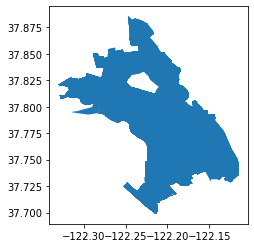

In [29]:
#double check it looks about right as Oakland.
gdf.plot()

In [31]:
#save as geojason
gdf.to_file("OalandHousingHabitabilityComplaints2013to2018Geocoded.geojson", driver='GeoJSON')

# Exploration of Healthy Housing Complaint Data

(From Presentation)

**Descriptive Analysis:** 
- where do complaints typically come from? 
- Most common building type (by # of units in building) or building age
- How many complaints per census tract?

**Output:**
- Dot map: complaints in Oakland (using addresses/parcels)
- Choropleth: Aggregated complaints at tract or block group level 
- Bar Charts: # Complaints per building characteristic (size of parcel, number of units, building age)
- Maps: distribution of each major ‘building type’ (SFH, 2-4 units, 5-15 units, 15+ units) 

**Method**

1) Dot Map

    a) Read in Oakland Boundary for Mapping
    b) Run code for Dot Map
    c) Save Dot Map to out_maps folder
    
2) Choropleth Map

    a) Create data frame of census tracts, their geometry, and the sum of addresses with complaints in that tract
    b) Run code for basic Choropleth Map
    c) Save Dot Map to out_maps folder
    
    
    

In [32]:
# 1a) bring in Oakland Boundary for Mapping
oakland_bounds = gpd.read_file(rf'C:\Users\amarq\Python_Projects\raw_data\City of Oakland City Limits.geojson')

In [37]:
#set the oakland_bounds CRS to match the rest of them
oakland_bounds.to_crs(tracts_gdf.crs, inplace=True)
oakland_bounds.crs == tracts_gdf.crs

True

In [38]:
#clip CA tracts into Oakland
tracts_oakland_clipped = gpd.clip(tracts_gdf, oakland_bounds).reset_index(drop=True)


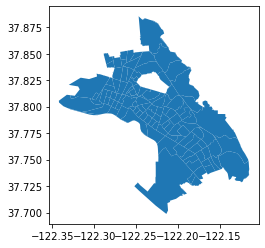

In [40]:
#map tracs_oakland to confirm
tracts_oakland_clipped.plot()

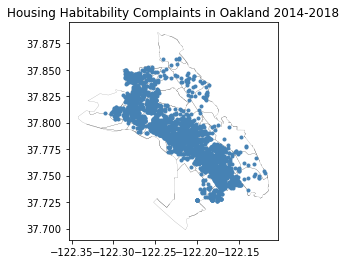

In [58]:
#create dot map with census tracts as outlines
# we use hh_gdf for the points and tracts_oakland_clipped for the background

fig, ax = plt.subplots()

tracts_oakland_clipped.plot(ax=ax,
                            color='None',
                            edgecolor='black',
                           linewidth=.1)

hh_gdf.plot(ax=ax,
           marker = '.',
           color = 'steelblue')

plt.title('Housing Habitability Complaints in Oakland 2014-2018')
plt.show()